# <center>자율주행 보조 시스템 만들기</center>



# <참고>
- 
- 

In [1]:
# 주요 라이브러리 버전 확인
import tensorflow as tf
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '../data/230223/'

print(tf.__version__)

/Users/louan/.pyenv/versions/3.9.13/envs/img/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.11.0


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-01 20:31:38.244584: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-01 20:31:38.244980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-03-01 20:31:58.572363: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


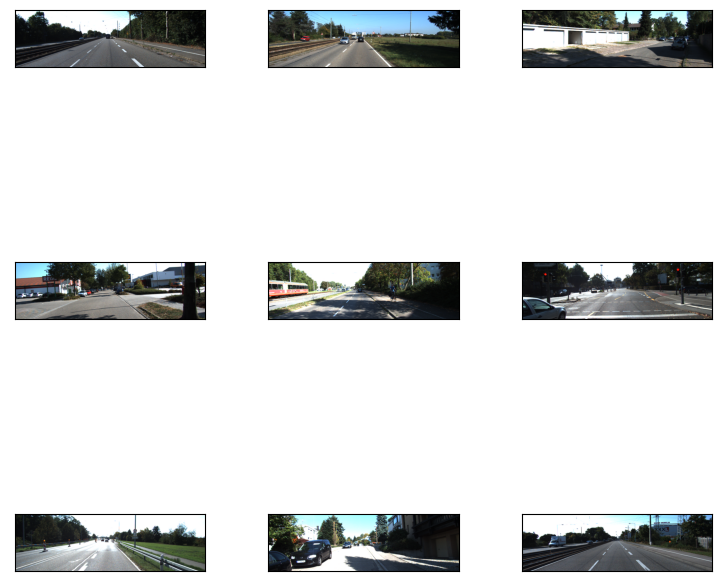

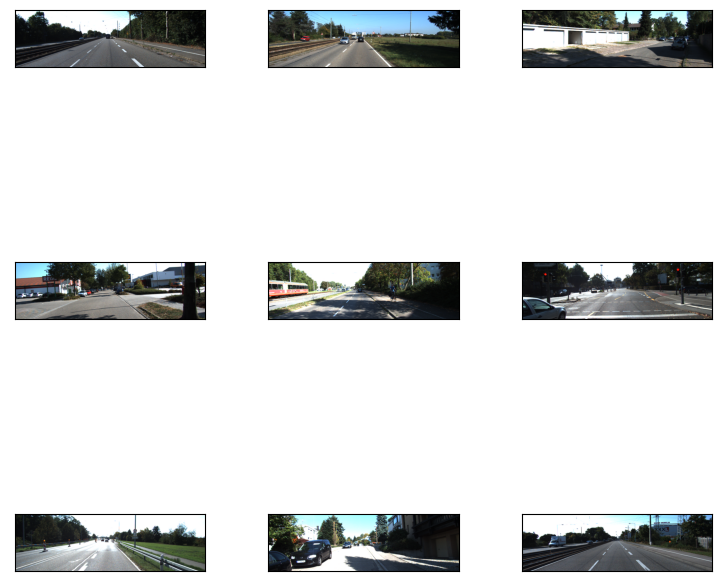

In [3]:
tfds.show_examples(ds_train, ds_info)

In [14]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.3.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='../data/230223/kitti/3.3.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'objects': Sequence({
            'alpha': float32,
          

## (2) 데이터 직접 확인하기
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([-1.14,  1.76, -1.71,  1.59, -1.63,  1.54, -2.79], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.48789334, 0.34122384],
       [0.40581334, 0.39613527, 0.54376   , 0.45011273],
       [0.2884    , 0.5558696 , 0.53632   , 0.64062804],
       [0.44786668, 0.4786071 , 0.55053335, 0.48861513],
       [0.35018668, 0.5454428 , 0.50938666, 0.6035749 ],
       [0.47485334, 0.51153785, 0.5339467 , 0.53144926],
       [0.38154668, 0.20065217, 0.54872   , 0.3496377 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.47, 1.6 , 3.66],
       [1.7 , 1.63, 4.08],
       [1.59, 1.59, 2.47],
       [1.81, 0.55, 1.19],
       [1.37, 1.59, 3.22],
       [1.49, 1.61, 3.74],
       [1.59, 1.63, 4.43]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float

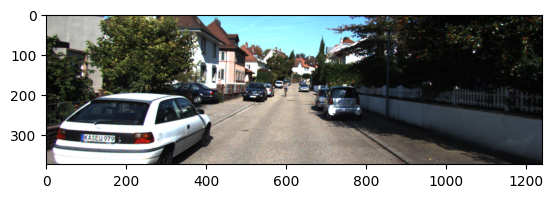

In [4]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

이미지와 라벨을 얻는 방법을 알게 되었습니다. 그렇다면 이렇게 얻은 이미지의 바운딩 박스(bounding box, bbox)를 확인하기 위해서는 어떻게 해야 할까요?

아래는 KITTI에서 제공하는 데이터셋에 대한 설명입니다.

```
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
```

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-input.max-800x600.png)

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-sample.max-800x600.png)

위 설명과 예시 이미지를 참고하셔서 이미지 위에 바운딩 박스를 그려서 시각화해 보세요!

Pillow 라이브러리의 ImageDraw 모듈을 참고하세요.

In [17]:
# objects['bbox']는 각 bbox에 대한 좌표를 비율로 나타냄
# 따라서 x_min, x_max, y_min, y_max를 구하기 위해서는 각 값에서 width 및 height를 곱해서 구해줘야 함
object_bbox = objects['bbox'].numpy()
print(object_bbox)

[[0.00266667 0.         0.48789334 0.34122384]
 [0.40581334 0.39613527 0.54376    0.45011273]
 [0.2884     0.5558696  0.53632    0.64062804]
 [0.44786668 0.4786071  0.55053335 0.48861513]
 [0.35018668 0.5454428  0.50938666 0.6035749 ]
 [0.47485334 0.51153785 0.5339467  0.53144926]
 [0.38154668 0.20065217 0.54872    0.3496377 ]]


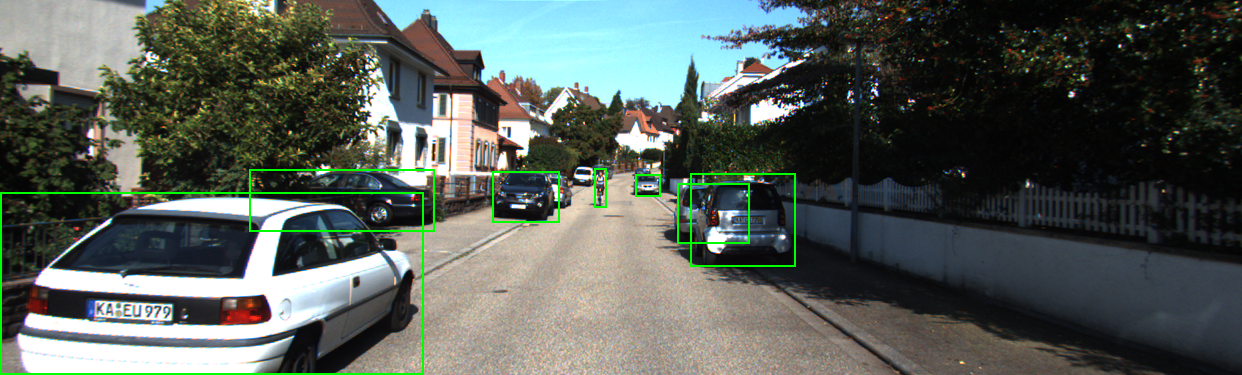

In [5]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    # 각 좌표를 rects에 stack 하고 각 rect값을 가져와서 그려줌
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for rect in rects:
        draw.rectangle(rect, outline=(0,255,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

```
<정답 예시>

def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())
```

In [18]:
# 데이터 파이프 라인의 단계
# 1. x와 y좌표 위치 교체
# 2. 무작위로 수평 뒤집기(Flip)
# 3. 이미지 크기 조정 및 패딩 추가
# 4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정


# x와 y좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

# 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

# 이미지 크기 조정 및 패딩 추가
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio
# 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [19]:
# 위의 함수들 연결 및 적용
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

## Anchor Box

In [8]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

##### Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형: 데이터를 모델이 학습 가능한 형태로 바꿔 줄 수 있게 되었으니 모델 생성 

In [20]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [11]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

## Model

In [12]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [13]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

# Project

## 1. 자율주행 시스템 만들기
---
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

In [21]:
model = build_head()

TypeError: build_head() missing 2 required positional arguments: 'output_filters' and 'bias_init'

In [7]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def check_object(img_path):
    num_person, car_width, car_height = 0,0,0
    return num_person, car_width, car_height

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
    num_person, car_width, car_height = check_object(img_path)
    if num_person >= 1 and (car_width >= 300 or car_height >= 300):
        stop_condition = True
    else:
        stop_condition = False

    if stop_condition:
        return "Stop"
    elif not stop_condition:
        return "Go"
        

print(self_drive_assist(img_path))

Go


## 2. 자율주행 시스템 평가하기
---
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [3]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

0점입니다.
